In [1]:
#import lib พื้นฐานที่จำเป็น
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore") # เอาไว้ ลบwarning 

In [2]:
#import dataset และ print เช็คข้อมูล
data = pd.read_csv("data.csv")
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [3]:
#ตัด feature ใน dataset ที่ไม่จำเป็นออกไป
data = data.drop(['Id' , 'Tags' , 'CreationDate'],axis=1) # ลบ feature ที่ไม่สำคัญออกไป
data['Y'] = data['Y'].map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2}) # encoded target class ใหม่ให้กลายเป็นตัวเลข ตามลำดับ

data.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


In [4]:
data['text'] = data['Title'] + ' ' + data['Body'] # รวม Title และ Body เข้าด้วยกันเพื่อเตรียมไปใส่ในmodel และเปลี่ยนชื่อเป็น text
data = data.drop(['Title','Body'],axis=1) # ทิ้งอันเดิม ออก
data.head()

,Y,text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,2,Why are Java Optionals immutable? <p>I'd like ...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky? <p>...
4,2,hide/show fab with scale animation <p>I'm usin...


In [5]:
import re # import regularexpression
def clean(text): # ฟังก์ชั่น ลบเครื่องหมายต่างๆ ที่ไม่ใช่text ออก เช่น? <> โดยใช้ regular expression
    text = text.lower() # เปลี่ยนให้เป็น lower case
    text = re.sub(r'[^(a-zA-Z)\s]','',text)
    return text

In [6]:
data['text'] = data['text'].apply(clean) # เรียกใช้ ฟังก์ชั่น clean

data.head()

,Y,text
0,0,java repeat task every random seconds pim alre...
1,2,why are java optionals immutable pid like to u...
2,2,text overlay image with darkened opacity react...
3,2,why ternary operator in swift is so picky pthe...
4,2,hideshow fab with scale animation pim using cu...


### สร้างvector ของข้อมูล โดยเลือกใช้ Word tokenized

In [7]:
X = data['text'].values # แยก feature กับ target class ออกจากกัน
y = data['Y'].values

In [8]:
def plot_history(model): # ฟังก์ชั่นสำหรับใช้ plot graph วัดประสิทธิภาพโมเดล
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### สร้าง simple RNN model 

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

tokenizer = Tokenizer(num_words=500) # ลองเปลี่ยนเลขได้ แต่ค่าที่เหมาะที่สุดตอนนี้คือ 500 แต่ลองปรับให้ลดลง
tokenizer.fit_on_texts(X)
vocab = tokenizer.word_index

In [10]:
X_tokenized = tokenizer.texts_to_sequences(X)
#max_seq_length = max(len(seq) for seq in X_tokenized)
X_padded = pad_sequences(X_tokenized, maxlen=100, padding='post', truncating='post') # สามารถเปลี่ยน maxlen ได้ แต่ค่าที่น่าจะเหมาะสมที่สุดคือ 100

ในการทำ word embeding จะเลือกใช้วิธี wordTokenized โดยการตั้งให้จำนวน numword = 500 เพราะอยากลองจำนวน numword เพราะเป็นค่าที่ให้ผลดีที่สุดใน 4 model ที่ผ่านมา


ส่วนในการ padding จะเลือกใช้ แค่ 100 เพราะค่าอื่นๆมันมากเกินไปและไม่มีความจำเป็นต่อการ train  แต่ก็สามารถเพิ่มหรือลดได้ถ้าต้องการ

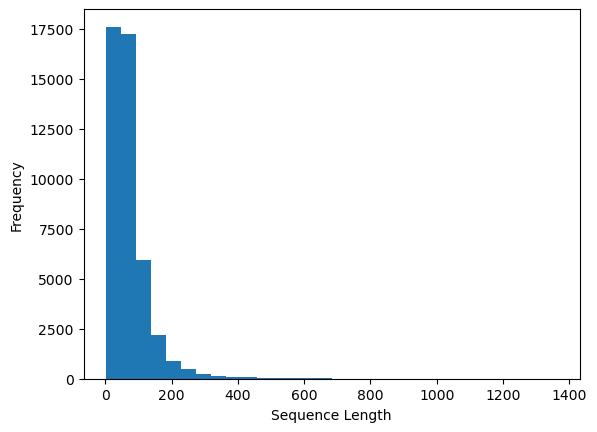

In [11]:
import matplotlib.pyplot as plt #กราฟสำหรับโชว์ว่า ควรตั้ง max สำหรับการ pad เท่าไหร่

# Plot histogram
plt.hist([len(seq) for seq in X_tokenized], bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42) #แบ่งเป็น 70/30

In [13]:
# ถ้าเคย train model ด้วย model.fit แล้วต้องการรันใหม่อีกครั้งให้เคลียร์ค่า weight เก่าก่อน 
# ถ้าไม่เคลียร์ค่า weight เก่า จะทำการ train ต่อจากครั้งล่าสุด

from keras.backend import clear_session
clear_session()

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=500, output_dim=30, input_length=100)) 
model.add(Dropout(0.3)) #dropout layers
model.add(LSTM(units=5))
model.add(Dropout(0.3)) #dropout layers
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 30)           15000     
                                                                 
 dropout_6 (Dropout)         (None, 100, 30)           0         
                                                                 
 lstm_3 (LSTM)               (None, 5)                 720       
                                                                 
 dropout_7 (Dropout)         (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                                                 
Total params: 15738 (61.48 KB)
Trainable params: 15738 (61.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ในการสร้าง simple RNN model ด้วยการใช้ embedding layer  จะประกอบไปด้วย

layer1

เป็น embedding layer ที่จะมี input อยู่ที่ 500 (อิงตามจำนวน word) output ที่30 และ input_length ที่ 100 (อิงตามการ padding)

dropout

เป็น regularization เพื่อลด overfit โดยตั้ง droprate ที่ 30%

LSTM layer

ทำหน้าที่จับ ความสำคัญของข้อมูล ในเวลาก่อนๆมาใช้ร่วมกับข้อมูล ณ เวลาปัจุบัน โดยจะตั้ง output space = 5 (unit) เนื่องจาก dataset ไม่จำเป็นต้องใช้จำนวนข้อมูลซํบซ้อนมากขนาดนั้น

dropout

เป็น regularization เพื่อลด overfit โดยตั้ง droprate ที่ 30%

output layers 

เป็น output ที่ตั้งตามจำนวนclass และใช้ softmax สำหรับการกระจายความน่าจะเป็นของข้อมูลออกตอน predict โดยตั้ง units 3 ตามจำนวน target class

### ในส่วน compile
loss = sparse_categorical_crossentropy = เอาไว้ใช้กับกรณี muticlassification (dataset ตัวนี้มี target 3 ตัว) ที่จะคำนวณค่าต่างๆออกมาเป็น ความน่าจะเป็นต่างๆแล้วนำไปเปรียบเทียบกับ กับค่าที่เป็น true

metric = accuracy = เป็นคะแนนที่เอาไว้บอกว่า model มีความสามารถในการ predict ออกมาได้ตรงมากขนาดไหน

adam = ใส่ไว้เป็นตัวลด loss เวลาที่ model กำลัง train อยู่

### การคำนวณparam ต่างๆ
โดย shape ของ X_train เราจะ เป็น (31500, 100)

embedding layer

คำนวณได้จาก input*output  = 500*30 = 15000 parameter (รวม weigth และ bias ทั้งหมดแล้ว)

dropout layer

ไม่มี การเพิ่มใดๆ เพียงแค่เป็นการลด overfit เท่านั้น

lstm layer

คำนวณได้จากสูตร 4*((input_dim+1) * units + units^2) = 4 * ((31+1) * 5 + 5^2) = 720 parameters 

จากการที่เรามี 5 unit ใน lstm ผลรวมทั้งหมดของ param ใน lstm layer จะเป็น = 5*720 = 3600 parameters

dropout layer

ไม่มี การเพิ่มใดๆ เพียงแค่เป็นการลด overfit เท่านั้น

output layers

คำนวณได้จาก input*units+units = 5*3+3 =18



### รวม parameter ทั้งหมดจะได้ 15000 + 720 + 18 = 15738 parameters


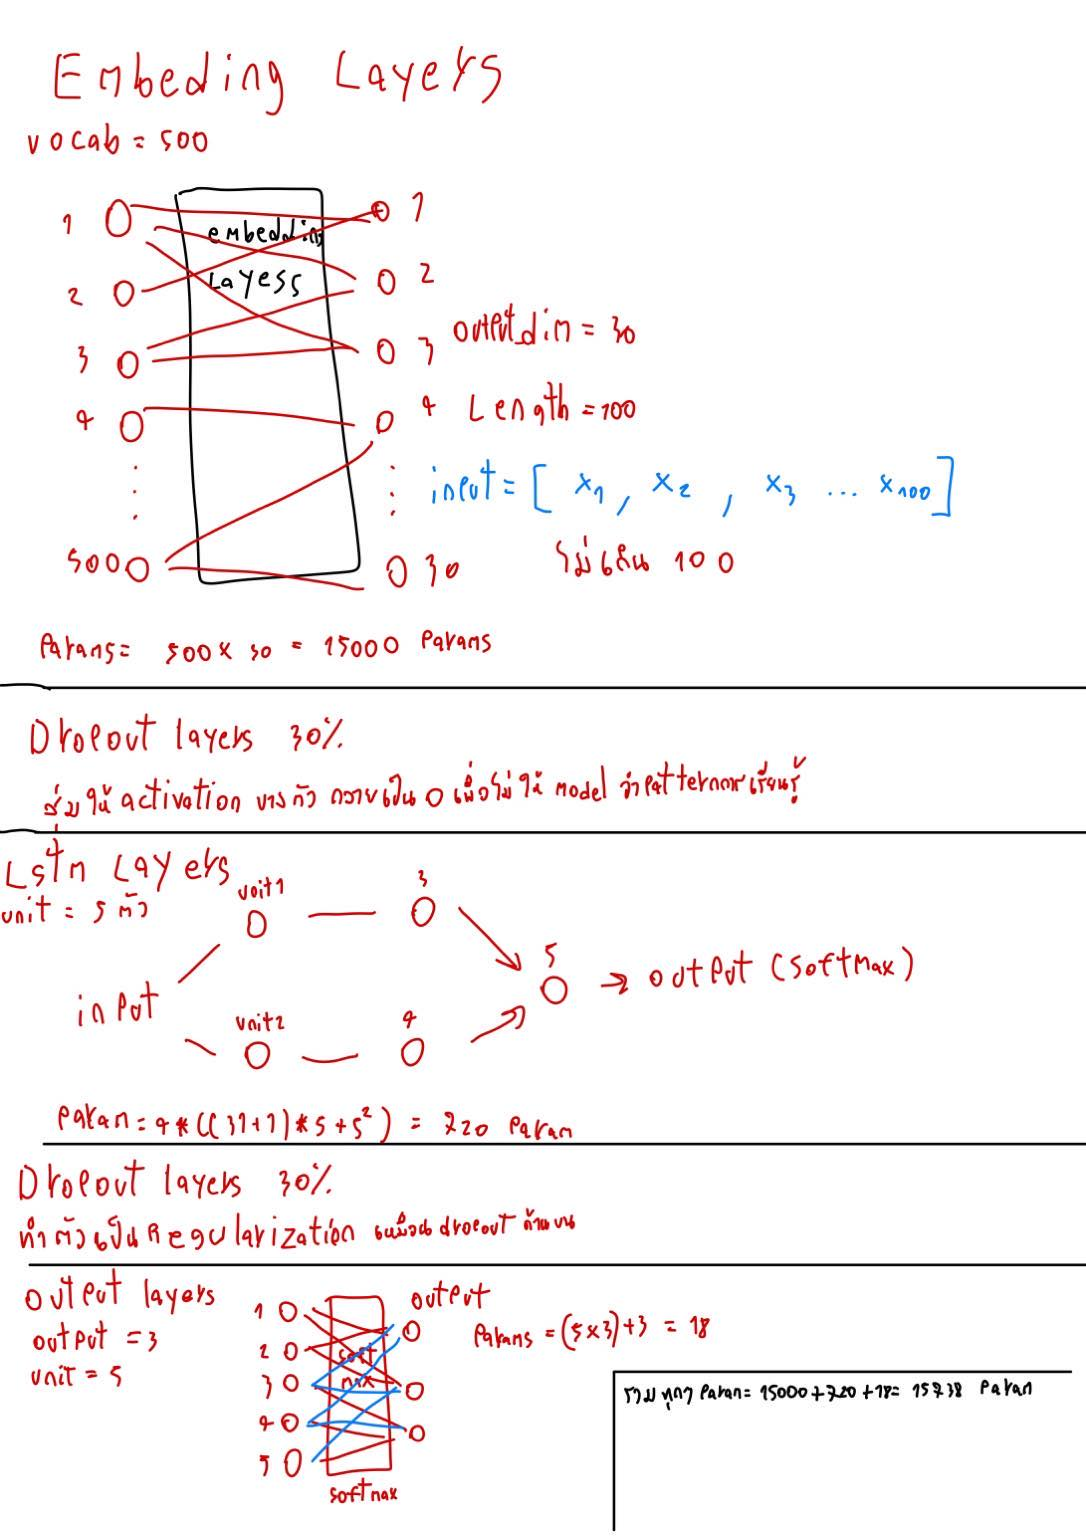

In [5]:
#fuction สำหรับการ insert รูปภาพลง jupyter notebook
import base64
from IPython.display import HTML

image_path = 'RNNMODEL.jpg'

with open(image_path, 'rb') as f:
    image_data = base64.b64encode(f.read()).decode('utf-8')

html_code = f'<img src="data:image/jpeg;base64,{image_data}" width="600" height="750">'
HTML(html_code)

In [22]:
from keras.callbacks import EarlyStopping

# Early stopping เพื่อลด overfit ในกรณีloss เด้งขึ้นมา และจะตัดรอบ กรณีถ้าไม่ดีขค้นภายใน15รอบ
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [23]:
simple = model.fit(
    X_train, y_train,
    epochs=50, # ทำ50รอบ
    batch_size=10, # สามารถลดได้ ถ้าอยาก generalize ข้อมูลและขึ้นอยู่กับเครื่อง
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
3150/3150 [==============================] - 43s 13ms/step - loss: 0.8000 - accuracy: 0.5916 - val_loss: 0.7441 - val_accuracy: 0.6143
Epoch 2/50
3150/3150 [==============================] - 38s 12ms/step - loss: 0.7304 - accuracy: 0.6195 - val_loss: 0.6669 - val_accuracy: 0.6391
Epoch 3/50
3150/3150 [==============================] - 38s 12ms/step - loss: 0.6772 - accuracy: 0.6263 - val_loss: 0.6586 - val_accuracy: 0.6339
Epoch 4/50
3150/3150 [==============================] - 38s 12ms/step - loss: 0.6413 - accuracy: 0.6417 - val_loss: 0.5931 - val_accuracy: 0.6713
Epoch 5/50
3150/3150 [==============================] - 38s 12ms/step - loss: 0.6313 - accuracy: 0.6536 - val_loss: 0.5963 - val_accuracy: 0.6702
Epoch 6/50
3150/3150 [==============================] - 38s 12ms/step - loss: 0.6240 - accuracy: 0.6583 - val_loss: 0.5966 - val_accuracy: 0.6825
Epoch 7/50
3150/3150 [==============================] - 38s 12ms/step - loss: 0.5921 - accuracy: 0.7061 - val_loss: 0.4928 -

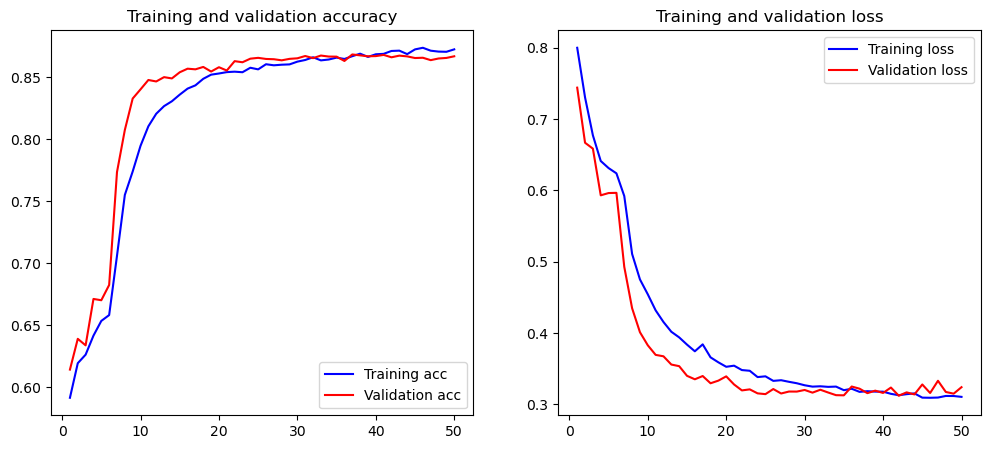

In [24]:
plot_history(simple)

จากการใช้ word embedding และ LSTM  จะพบว่า model ไม่ทำการ early stop เลยเพราะโอกาสเกิดoverfit ของข้อมูลนั้นค่อนข้างคงที่ไปพร้อมๆกับ loss ของ accuracy ถึงแม้ตอนเริ่มต้น loss จะสูงแต่หลังจากการtrain ไปเรื่อยๆพบว่า model นั้นรักษาระดับค่า validation loss ได้เป็นอย่างดี ถึงจะtrain ไป50 epoch ติดกันก็ตาม แสดงว่า model สามารถทำงานได้อย่างมีประสิทธิภาพมากกว่าmodel อื่นๆก่อนหน้า เพราะทั้ง training และ validation นั้นมีความใกล้เคียงกันอย่างมาก แต่ถึงอย่างไร model ก็สามารถปรับแต่งเพิ่มเติมได้ในอนาคตถ้าหากพบว่ามีจุดที่ต้องปรับปรุงอยู่

### เทียบคะแนนกับ model ตัวอื่นๆ 

DNN with CountVectorizer (ตัวที่แย่ที่สุด)

Train Accuracy : 0.925
Validation Accuracy : 0.875


DNN with Flattern layers and word embeddings (ตัวที่ดีที่สุด อันดับ3)

Training Accuracy: 0.8716
Validation Accuracy: 0.8331


DNN with GlobalMaxpooling layer and word embeddings (ตัวที่ดีที่สุด อันดับ 2 )

Training Accuracy: 0.8722
Validation Accuracy: 0.8620


DNN with ConVU1d and word embeddings (อันดับ4)

Training Accuracy: 0.8692
Validation Accuracy: 0.8453

simple RNN with LSTM  (ตัวที่ให้ผลดีที่สุดในตอนนี้ )

Training Accuracy: 0.85
Validation Accuracy: 0.85